# Find 3 Disks
Given an image with a background texture, and three overlaid texured disks, predict the centerpoint of the labeled “most concpicuous disk.”

In [1]:
# import sys
# print (sys.version)

import gc
import math
import time
import random
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# Import DiskFind utilities for PredatorEye.
import sys
sys.path.append('/content/drive/My Drive/PredatorEye/shared_code/')
import DiskFind as df

df.set_global_random_seed(20220108)
model_save_directory = '/content/drive/My Drive/PredatorEye/saved_models/'

TensorFlow version: 2.7.0


# Generate uniform texture dataset

In [2]:
# # dataset_size = 10
# dataset_size = 1000
# image_size = 128
# image_depth = 3  # for RGB
# # disk_radius = image_size * df.relative_disk_radius()

# def MakeUniformTextureDataset():
#     dataset_shape = (dataset_size, image_size, image_size, image_depth)
#     dataset = np.zeros(dataset_shape, dtype=np.float32)
#     # for i in range(dataset_size):
#     for i in tqdm(range(dataset_size)):
#         dataset[i, :, :, :] = generateUniformExample()
#         # Draw image for debugging
#         if ((i % 50) == 0) and (i < (50 * 10)):
#             # df.draw_image(dataset[i, :, :, :])
#             df.draw_image(generateUniformExample())
#     return dataset


# def MakeUniformTextureDataset(dataset_size, image_size, image_depth):
#     dataset_shape = (dataset_size, image_size, image_size, image_depth)
#     dataset = np.zeros(dataset_shape, dtype=np.float32)
#     # for i in range(dataset_size):
#     for i in tqdm(range(dataset_size)):
#         dataset[i, :, :, :] = generateUniformExample(image_size, image_depth)
#         # Draw image for debugging
#         if ((i % 50) == 0) and (i < (50 * 5)):
#             df.draw_image(dataset[i, :, :, :])
#     return dataset


# def MakeUniformTextureDataset(dataset_size, image_size, image_depth):
#     dataset_shape = (dataset_size, image_size, image_size, image_depth)
#     # dataset = np.zeros(dataset_shape, dtype=np.float32)
#     dataset = []
#     # for i in range(dataset_size):
#     for i in tqdm(range(dataset_size)):
#         # dataset[i, :, :, :] = generateUniformExample(image_size, image_depth)
#         (image, label) = generateUniformExample(image_size, image_depth)
#         # dataset[i, :, :, :] = image
#         dataset.append(image)
#         # TODO TEMP -- Draw image for debugging
#         if ((i % 50) == 0) and (i < (50 * 5)): df.draw_image(image)
#     return dataset


def MakeUniformTextureDataset(dataset_size, image_size, image_depth):
    dataset_shape = (dataset_size, image_size, image_size, image_depth)
    # dataset = np.zeros(dataset_shape, dtype=np.float32)
    # dataset = []
    images = []
    labels = []
    # for i in range(dataset_size):
    for i in tqdm(range(dataset_size)):
        # dataset[i, :, :, :] = generateUniformExample(image_size, image_depth)
        (image, label) = generateUniformExample(image_size, image_depth)
        # dataset[i, :, :, :] = image
        # dataset.append(image)
        images.append(image)
        labels.append(label)
        # # TODO TEMP -- Draw image for debugging
        # if ((i % 50) == 0) and (i < (50 * 5)): df.draw_image(image)
    return (images, labels)

# def generateUniformExample():

# blah blah
# return an image (pixel tensor) and a label as (x, y) tensor
def generateUniformExample(image_size, image_depth):
    bg_color = np.random.random_sample(image_depth)
    fg_color = np.random.random_sample(image_depth)
    disk_radius = image_size * df.relative_disk_radius()
    image_shape = (image_size, image_size, image_depth)
    image = np.full(image_shape, bg_color, dtype=np.float32)

    # Find 3 non-overlapping disk positions inside image.
    def random_center():
        s = image_size - (2 * disk_radius)
        return (np.random.random_sample(2) * s) + disk_radius
    centers = [random_center()]
    min_dist = 3 * disk_radius
    while len(centers) < 3:
        c = random_center()
        all_ok = True
        for o in centers:
            if (df.dist2d(c, o) < min_dist):
                all_ok = False
        if (all_ok):
            centers.append(c)

    # Draw 3 soft-edged disks, with colors progressively more like background.
    def draw_disk(center, color):
        cx = int(center[0])
        cy = int(center[1])
        dr = int(disk_radius)
        for x in range(cx - dr, cx + dr + 1):
            for y in range(cy - dr, cy + dr + 1):
                d = math.sqrt(math.pow(x - cx, 2) + math.pow(y - cy, 2))
                if (d <= dr):
                    blend = df.spot_utility((x, y), center, dr * 0.85, dr)
                    image[x, y, :] = df.interpolate(blend, bg_color, color) 
    draw_disk(centers[0], fg_color)
    draw_disk(centers[1], df.interpolate(0.33, fg_color, bg_color))
    draw_disk(centers[2], df.interpolate(0.66, fg_color, bg_color))

    # return image
    # print('centers[0] =', centers[0])
    # print('type(centers[0]) =', type(centers[0]))
    label = centers[0] / image_size

    # TODO When I visualized the labels, they appeared xy flipped
    #      trying "unflipping them"
    label = np.array((label[1], label[0]))

    return (image, label)

df.reset_random_seeds()
start_time = time.time()


# maybe keyword args?
# dataset_size = 1000
dataset_size = 5000
image_size = 128
image_depth = 3  # for RGB
(uniform_dataset_images,
 uniform_dataset_labels) = MakeUniformTextureDataset(dataset_size,
                                                     image_size,
                                                     image_depth)
 

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')


  0%|          | 0/5000 [00:00<?, ?it/s]

Elapsed time: 174 seconds (2 minutes).


# Split dataset

In [3]:
(images_train, images_test,
 labels_train, labels_test) = train_test_split(uniform_dataset_images,
                                              uniform_dataset_labels,
                                              test_size=0.2)
 
# Convert from Python lists to np arrays.
images_train = np.array(images_train, dtype=np.float32)
labels_train = np.array(labels_train, dtype=np.float32)
images_test = np.array(images_test, dtype=np.float32)
labels_test = np.array(labels_test, dtype=np.float32)


# Visualize dataset sample

737 : ( 0.44845277 , 0.68487316 )


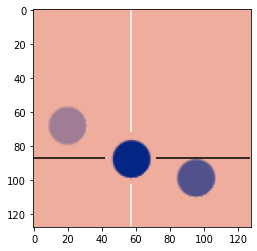

102 : ( 0.78322154 , 0.49190235 )


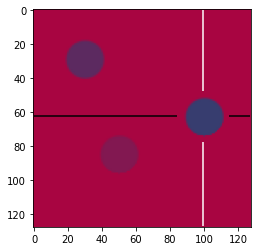

648 : ( 0.4391604 , 0.29098514 )


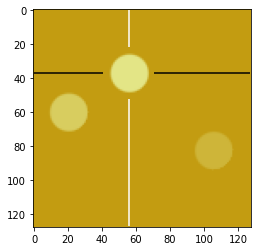

603 : ( 0.80910224 , 0.83507097 )


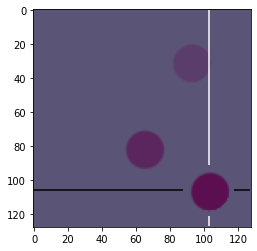

234 : ( 0.17028552 , 0.49625862 )


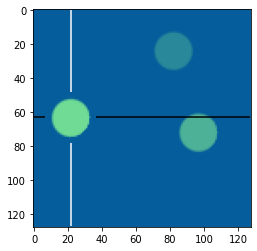

779 : ( 0.30479866 , 0.3153397 )


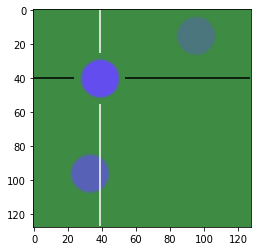

258 : ( 0.79624563 , 0.24958189 )


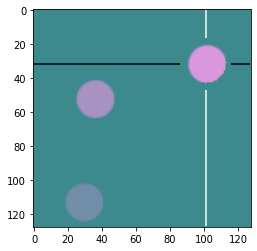

792 : ( 0.48156598 , 0.23990202 )


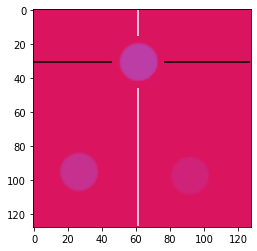

620 : ( 0.33542642 , 0.13730028 )


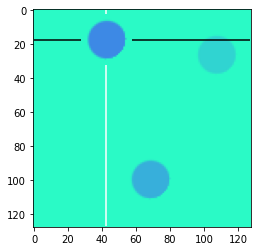

527 : ( 0.47442982 , 0.7491051 )


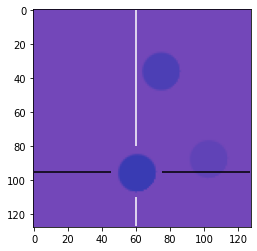

In [4]:
# Draw some results to understand performance
# (Started from Find_Conspicuous_Disk.draw_results())
def visualize_dataset_sample(images, labels, count = 10):
    # for i in random.sample(range(X_test.shape[0]), count) :
    for i in range(count):
        r = random.randrange(0, images.shape[0])
        # pixel_tensor = X_test[i, :, :, :]
        pixel_tensor = images[r, :, :, :]
        label = labels[r, :]
        # predict = model.predict(tf.convert_to_tensor([pixel_tensor]))[0]
        # x = predict[0]
        # y = predict[1]
        # print(r, ": (", x, ",", y, ")")
        print(r, ": (", label[0], ",", label[1], ")")
        # DiskFind.draw_image(pixel_tensor, [x, y])
        df.draw_image(pixel_tensor, label)

df.reset_random_seeds()
visualize_dataset_sample(images_test, labels_test)

# Build and train model

Epoch 1/100
32/32 [==============================] - 8s 150ms/step - loss: 0.7529 - accuracy: 0.5033 - in_disk: 0.0347 - val_loss: 0.0750 - val_accuracy: 0.5140 - val_in_disk: 0.0480
Epoch 2/100
32/32 [==============================] - 4s 115ms/step - loss: 0.0628 - accuracy: 0.5030 - in_disk: 0.0425 - val_loss: 0.0557 - val_accuracy: 0.5140 - val_in_disk: 0.0490
Epoch 3/100
32/32 [==============================] - 4s 115ms/step - loss: 0.0589 - accuracy: 0.5048 - in_disk: 0.0515 - val_loss: 0.0560 - val_accuracy: 0.5140 - val_in_disk: 0.0450
Epoch 4/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0593 - accuracy: 0.5013 - in_disk: 0.0485 - val_loss: 0.0560 - val_accuracy: 0.4920 - val_in_disk: 0.0430
Epoch 5/100
32/32 [==============================] - 4s 117ms/step - loss: 0.0589 - accuracy: 0.4965 - in_disk: 0.0457 - val_loss: 0.0586 - val_accuracy: 0.5140 - val_in_disk: 0.0410
Epoch 6/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0576 - a

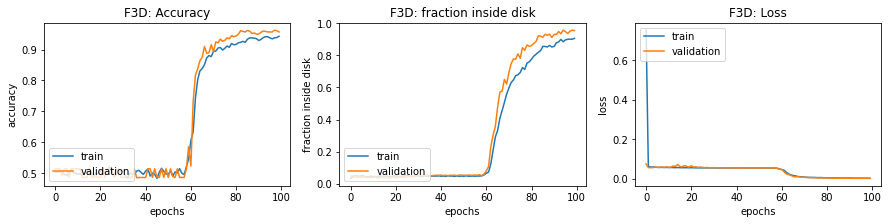

Elapsed time: 385 seconds (6 minutes).
INFO:tensorflow:Assets written to: /content/drive/My Drive/PredatorEye/saved_models/20220109_1453_Find_3_Disks/assets
Saved trained model to /content/drive/My Drive/PredatorEye/saved_models/20220109_1453_Find_3_Disks


In [5]:
# Run a model.
df.reset_random_seeds()
start_time = time.time()
fcd_model_timestamp = df.timestamp_string()
(model, history) = ([], [])  # To release memory when rerunning in notebook.
gc.collect()

model = df.make_disk_finder_model(images_train)
history = df.run_model(model,
                       images_train, labels_train, images_test, labels_test,
                       # 50,  # fcd_epochs,
                       100,  # fcd_epochs,
                       128, # fcd_batch_size,
                       'F3D')

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

# model.save(model_save_directory + fcd_model_timestamp)
model_save_path = model_save_directory + fcd_model_timestamp + '_Find_3_Disks'
model.save(model_save_path)
print('Saved trained model to', model_save_path)

# Visualize prediction sample

737 : ( 0.46090466 , 0.6425646 )


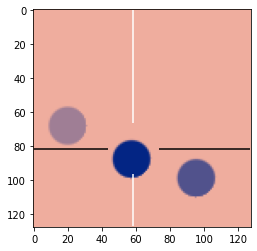

102 : ( 0.7699983 , 0.49422678 )


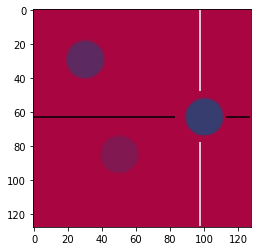

648 : ( 0.40107724 , 0.2309038 )


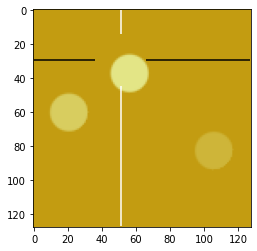

603 : ( 0.7663542 , 0.83562094 )


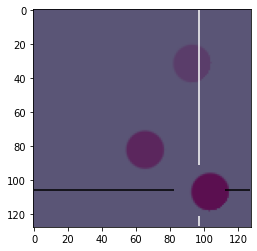

234 : ( 0.15875357 , 0.48965725 )


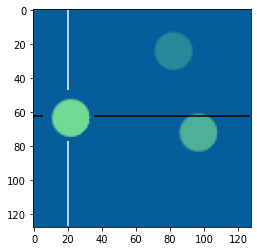

779 : ( 0.25200605 , 0.31177723 )


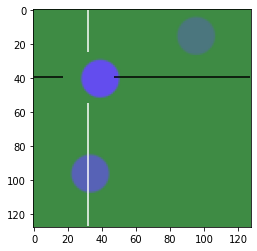

258 : ( 0.7971686 , 0.2381036 )


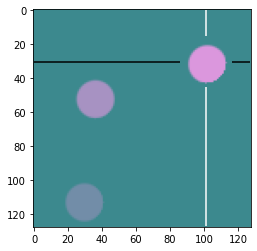

792 : ( 0.5184181 , 0.21232992 )


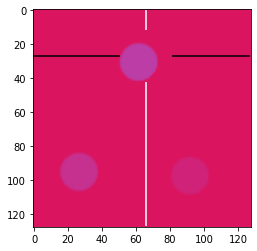

620 : ( 0.37136337 , 0.116041094 )


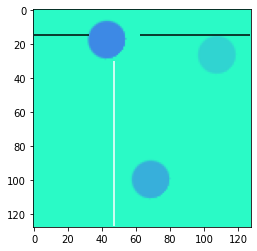

527 : ( 0.47672048 , 0.7864051 )


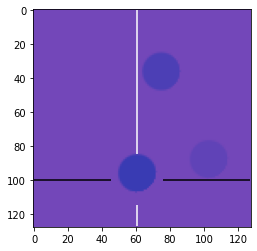

In [6]:
# Draw some results to understand performance
# (Started from Find_Conspicuous_Disk.draw_results())
def visualize_prediction_sample(model, images, labels, count = 10):
    for i in range(count):
        r = random.randrange(0, images.shape[0])
        # pixel_tensor = X_test[i, :, :, :]
        pixel_tensor = images[r, :, :, :]
        label = labels[r, :]

        predict = model.predict(tf.convert_to_tensor([pixel_tensor]))[0]
        # x = predict[0]
        # y = predict[1]

        # print(r, ": (", x, ",", y, ")")
        # print(r, ": (", label[0], ",", label[1], ")")
        print(r, ": (", predict[0], ",", predict[1], ")")
        # DiskFind.draw_image(pixel_tensor, [x, y])
        # df.draw_image(pixel_tensor, label)
        df.draw_image(pixel_tensor, predict)

df.reset_random_seeds()
visualize_prediction_sample(model, images_test, labels_test)